# Velocity dispersion influence of ULDM soliton

In this notebook we try to see the influence in the velocity dispersion when a core given by the soliton of Ultra Light Dark Matter is added in a Mass sheet degenerate way.
This notebook is inspired from [this notebook](https://github.com/TDCOSMO/hierarchy_analysis_2020_public/blob/master/MST_impact/MST_pl_cored.ipynb) from S. Birrer.

Use [this fork](https://github.com/lucateo/lenstronomy/tree/uldm-teodori-inverse-thetac-kappaE) of lenstronomy to make this run, in order not to have problems.

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import copy
import corner
import astropy.io.fits as pyfits
import pickle
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

import lenstronomy.Util.constants as const
from lenstronomy.LensModel.Profiles.uldm_pl import Uldm_PL
from lenstronomy.LensModel.Profiles.uldm import Uldm

np.random.seed(30)
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=74.3, Om0=0.31, Ob0=0.)
cosmo_cmb = FlatLambdaCDM(H0=67.4, Om0=0.31, Ob0=0.)
lens_cosmo = LensCosmo(z_lens = z_lens, z_source = z_source, cosmo = cosmo)
lens_cosmo_cmb = LensCosmo(z_lens = z_lens, z_source = z_source, cosmo = cosmo_cmb)

# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units # photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
kernel_size = 91

# initial input simulation
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables

# lensing quantities
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=-0.5, gamma=0.09) # shear quantities
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  # shear values

theta_E = 1.2
kappa_0 = 0.1
gamma = 1.98

kwargs_spemd = {'theta_E': theta_E, 'gamma': gamma, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.05, 'e2': 0.05}  # parameters of the deflector lens model
kwargs_uldm = {'kappa_0': 0.1, 'inverse_theta_c': 0.1, 'slope': 3.78, 'center_x': 0.0, 'center_y': 0.0}  # parameters of the deflector lens model

# the lens model is a superposition of an elliptical lens model with external shear
lens_model_list = ['PEMD', 'SHEAR']
lens_model_list_uldm = ['PEMD', 'SHEAR', 'ULDM']

kwargs_lens = [kwargs_spemd, kwargs_shear]
kwargs_lens_uldm = [kwargs_spemd, kwargs_shear, kwargs_uldm]

lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)
lens_model_class_uldm = LensModel(lens_model_list=lens_model_list_uldm, z_lens=z_lens, z_source=z_source, cosmo=cosmo_cmb)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'
source_x = 0.
source_y = 0.1
# Sersic parameters in the initial simulation for the source
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 2000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)

# lens light model
r_eff = 0.8
lens_light_model_list = ['HERNQUIST']
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
kwargs_hernquist = {'amp': 4000, 'Rs': r_eff*0.551, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_hernquist]

point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

In [2]:
### KINEMATICS
# observational conditions of the spectroscopic campagne
R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7

kwargs_aperture = {'aperture_type': 'slit', 'length': R_slit, 'width': dR_slit, 'center_ra': 0.05, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OM' # Osipkov-Merritt
aperture_type = 'slit'

kwargs_numerics_galkin = {'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals

r_ani = 1.
kwargs_anisotropy = {'r_ani': r_ani}
kwargs_seeing = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}
kwargs_model = {'lens_model_list': lens_model_list,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }
kwargs_model_uldm = {'lens_model_list': lens_model_list_uldm,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

from lenstronomy.Analysis.kinematics_api import KinematicsAPI
kin_api = KinematicsAPI(z_lens, z_source, kwargs_model, cosmo=cosmo,
                        lens_model_kinematics_bool=[True, False], light_model_kinematics_bool=[True],
                        kwargs_aperture=kwargs_aperture, kwargs_seeing=kwargs_seeing,
                        anisotropy_model=anisotropy_model, kwargs_numerics_galkin=kwargs_numerics_galkin,
                        sampling_number=10000,  # numerical ray-shooting, should converge -> infinity
                        Hernquist_approx=True)

kin_api_uldm = KinematicsAPI(z_lens, z_source, kwargs_model_uldm, cosmo=cosmo_cmb,
                        lens_model_kinematics_bool=[True, False, True], light_model_kinematics_bool=[True],
                        kwargs_aperture=kwargs_aperture, kwargs_seeing=kwargs_seeing,
                        anisotropy_model=anisotropy_model, kwargs_numerics_galkin=kwargs_numerics_galkin,
                        sampling_number=10000,  # numerical ray-shooting, should converge -> infinity
                        Hernquist_approx=True)

In [3]:
### Velocity dispersion dependence with core, useful functions
def find_kappa_tilde(x, *arguments):

    kappa_tilde = x
    kappa_E, inverse_theta_c, theta_E = arguments
    tilde_theta = (1 - kappa_E)*theta_E
    kappa_E_eq = Uldm_PL()._kappa_E(theta_E, tilde_theta, kappa_tilde, inverse_theta_c)
    eq1 = (1 - kappa_E_eq)*theta_E - tilde_theta
    return eq1

def kappa_tilde_finder(kappa_E, inverse_theta_c, theta_E):

    arguments = (kappa_E, inverse_theta_c, theta_E)
    kappa_tilde = fsolve(find_kappa_tilde, 0.05, args=arguments)
    return kappa_tilde[0]

kappa_E = 0.09
kappa_0_list = []
def velocity_dependence(r_eff_list, inverse_theta_c):

    vel_disp_list = []
    vel_disp_0_list = []

    kwargs_lens_kin = copy.deepcopy(kwargs_lens_uldm)
    kwargs_lens_light_kin = copy.deepcopy(kwargs_lens_light)

    kappa_ext = 0
    kappa_tilde = kappa_tilde_finder(kappa_E, inverse_theta_c, theta_E)
    tilde_theta = (1 - kappa_E)*theta_E
    kappa_0 = Uldm_PL()._kappa_0_real(tilde_theta, kappa_tilde, inverse_theta_c)
    kappa_0_list.append(kappa_0)
    slope_current = Uldm_PL()._slope(tilde_theta, kappa_tilde, inverse_theta_c)
    kwargs_lens_kin[2]['kappa_0'] = kappa_0
    kwargs_lens_kin[2]['inverse_theta_c'] = inverse_theta_c
    kwargs_lens_kin[2]['slope'] = slope_current
    kwargs_lens_kin[0]['theta_E'] = tilde_theta

    for r_eff_current in r_eff_list:
        vel_averaged_array = []
        vel_0_averaged_array = []
        kwargs_lens_light_kin[0]['Rs'] = 0.551* r_eff_current
        for i in range(20):
            vel_disp_0 = kin_api.velocity_dispersion(kwargs_lens, kwargs_lens_light_kin, kwargs_anisotropy, r_eff=None, theta_E=None,)
            vel_disp = kin_api_uldm.velocity_dispersion(kwargs_lens_kin, kwargs_lens_light_kin, kwargs_anisotropy, r_eff=None, theta_E=None, kappa_ext=kappa_ext)
            vel_averaged_array.append(vel_disp)
            vel_0_averaged_array.append(vel_disp_0)
        vel_disp_list.append(np.sum(vel_averaged_array)/20.)
        vel_disp_0_list.append(np.sum(vel_0_averaged_array)/20.)
    return np.array(vel_disp_list), np.array(vel_disp_0_list)

# Let it run
num_points_r_eff = 20
r_eff_list = np.linspace(0.001, 2., num_points_r_eff)
inverse_theta_c_list = [0.2, 0.1, 0.05]
vel_disp_list_r = []
vel_disp_0_r = []

for inverse_theta_core in inverse_theta_c_list:
    vel_disp_list, vel_disp_0  = velocity_dependence(r_eff_list, inverse_theta_core)
    vel_disp_list_r.append(vel_disp_list)
    vel_disp_0_r.append(vel_disp_0)

Velocity array full model: [array([208.87653527, 218.36952001, 224.69033151, 229.60997677,
       235.75714845, 240.83390656, 244.7128121 , 248.48154416,
       252.21133078, 255.71544807, 259.14881307, 261.84771613,
       264.39279215, 266.92541676, 269.43820343, 271.88544635,
       273.6824549 , 276.06920698, 277.78807423, 279.47337892]), array([208.73059438, 218.10127467, 224.29079618, 229.08454459,
       235.2279178 , 240.13921637, 244.06685211, 247.75863079,
       251.47369194, 255.02359099, 258.39898349, 261.0367032 ,
       263.72064598, 266.32223203, 268.81293765, 271.28119592,
       273.12784387, 275.59256615, 277.30997805, 279.05596509]), array([208.64413782, 217.9194654 , 224.0664063 , 228.72197845,
       234.77466106, 239.6144495 , 243.52264627, 247.29622761,
       250.81275757, 254.32655636, 257.7401438 , 260.41272999,
       263.09162299, 265.63794107, 268.19539059, 270.52494557,
       272.44705708, 274.77397329, 276.57243051, 278.38903457])]
Velocity null model [

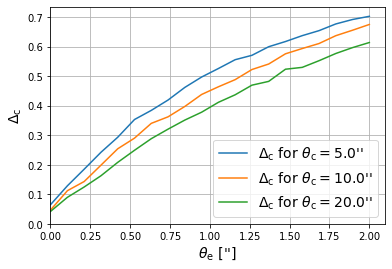

In [5]:
# Print values
print('Velocity array full model:', vel_disp_list_r)
print('Velocity null model', vel_disp_0_r)
# Plot the result
for i in range(len(inverse_theta_c_list)):
    vel_disp_list = vel_disp_list_r[i]
    vel_disp_0_list = vel_disp_0_r[i]
    plt.plot(r_eff_list, (vel_disp_list**2/vel_disp_0_list**2 - 1 + kappa_E)/kappa_E, label=r'$\Delta_{\rm c}$ for $\theta_{\rm c} =$'+str(1/inverse_theta_c_list[i])+repr('') )
plt.ylabel(r'$\Delta_{\rm c}$', fontsize = 14)
plt.legend(fontsize=14)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel(r'$\theta_{\rm e} \ $'+repr(['']), fontsize=14)
plt.grid()
plt.show()
#  plt.savefig('Sigma_Dispersion_r_eff.pdf')